In [2]:
import argparse
from dataset import VADDataset#, collate
from solver import Solver
from self_attentive_vad import SelfAttentiveVAD, SelfAttentiveVAD_Normalize, SelfAttentiveVAD_Normalize_Convoutput
import torch
from torch.utils.data import DataLoader
import config
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

parser = config.parser
args= parser.parse_args("")

In [3]:
tt_dataset = VADDataset(json_path = '/home/yhjeon/AGC/src/vad/test.json', sample_rate=args.sample_rate, wav_len=args.wav_len, win_len=args.win_len, hop_len=args.hop_len)
tt_dataloader = DataLoader(tt_dataset, batch_size = 1, shuffle=True, num_workers = args.num_workers)

data = {'tt_loader': tt_dataloader}

model = SelfAttentiveVAD_Normalize_Convoutput(args.win_len, args.hop_len, 16, 16, 1, 0)
    
package = torch.load('/home/yhjeon/AGC/final.pth.tar')
model.load_state_dict(package['state_dict'])
model.cpu()
model.eval()

Processing 401 of 500
Done!


SelfAttentiveVAD_Normalize_Convoutput(
  (feature_layer): Conv1d(1, 16, kernel_size=(480,), stride=(160,), bias=False)
  (input_layer): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): SinusoidalPositionalEncoding()
    (2): Dropout(p=0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attention): MultiHeadAttention(
          (query_projection): Linear(in_features=16, out_features=16, bias=True)
          (key_projection): Linear(in_features=16, out_features=16, bias=True)
          (value_projection): Linear(in_features=16, out_features=16, bias=True)
          (final_projection): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (softmax): Softmax(dim=3)
        )
        (self_attention_sublayer): Sublayer(
          (layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=

elapsed time: 23.5ms
torch.Size([1, 48000])


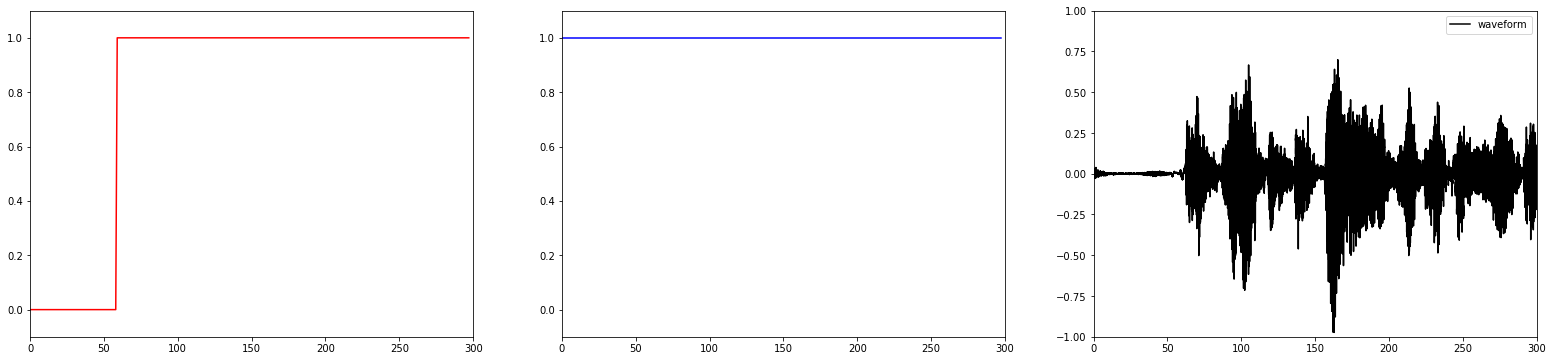

In [19]:
threshold = 0.5
import numpy
import time
import sounddevice as sd
import soundfile as sf

def moving_average(a, n=3) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i, data in enumerate(tt_dataloader):
    start = time.time()
    wav, gt = data['wav'], data['label']
    wav = wav.cpu()
    start = time.time()
    est_label = model(wav)
    print('elapsed time:{0: .1f}ms'.format((time.time() - start) * 1000))
    est_label = est_label[0].cpu().detach().numpy()
    est_label_original = est_label[0]
    est_label = numpy.pad(est_label, 5, mode='edge')
    est_label = moving_average(est_label, n=11)

    gt = gt[0].float().cpu()
    wav = wav.cpu()
    print(wav.shape)
    wav_original = wav.T
    wav = torch.nn.functional.normalize(wav, dim=1) * ((wav.shape[1]) ** 0.5)
    est_label = numpy.where(est_label > threshold, 1, 0)
    
    plt.figure(figsize=[27, 6])
    plt.subplot(1, 3, 1)
    plt.axis([0, 300, -0.1, 1.1])
    plt.plot(est_label, color='red', label='estimate')
    plt.subplot(1, 3, 2)
    plt.axis([0, 300, -0.1, 1.1])
    plt.plot(gt, color='blue', label='groudtruth')
    plt.subplot(1, 3, 3)
    plt.axis([0, 300, -1, 1])
    plt.plot([i / 160 for i in range(48000)],  wav_original, color='black', label='waveform')
    plt.legend()
    plt.show()

    sf.write('test_wave.wav', data=wav_original, samplerate=16000)

    break